# DS 5001 Project Notebook: Greek and Roman Mythology

- David Vann (dv6bq@virginia.edu)
- DS 5001
- 5 May 2021

In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import nltk

from eta_modules.preprocessing import Document, Corpus
from eta_modules.analysis import HierarchicalClusterAnalysis, PCA, TopicModel

In [2]:
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')

## Reading in the data

We start by loading in the XML files for each work and parsing them to a reasonable degree with BeautifulSoup and NLTK. 

Since these works are all either plays or poems/epics, the concept of a "chapter" or "paragraph" doesn't translate perfectly compared to, e.g., a novel. However, the Perseus Digital Library (where these files are sourced from) has added at least top-level divisions to break up texts. In some cases, these divisions truly exist in the text (for example, *The Iliad* is broken into 24 books); in other cases, like plays, these divisions don't seem to be directly present in the text, but are akin to something like a "scene". I've considered all of these largest divisions as "chapters".

To get at something like a "paragraph", I used a different approach based on whether the work was a play or not:

- For plays, I used each speaker section (denoted by a "\<sp>" in the files) as a "paragraph". 
- For everything else, there wasn't a built-in tag for "paragraph"-type divisions, but there is a self-closing "milestone" tag that marks the start of a new "card" used on the Perseus website to denote content to be displayed on one page. Since these are self-closing, they don't actually enclose the particular block of text that I wanted to get at; instead, I replaced these with newlines and split up text based on a double newline, which seemed to give fairly satisfactory results.

In [3]:
def parse_corpus(docpaths, tfidf_bag=['work_id', 'chapter_id'], tfidf_methods=['n', 'max', 'bool']):
    doc_list = []
    for path in docpaths:
        doc = Document(path)
        doc.parse_text_to_paras()
        doc.tokenize(remove_pos_tuple=True, remove_ws=True)
        doc_list.append(doc)

    corpus = Corpus(doc_list)
    corpus.extract_annotate_vocab()
    corpus.compute_tfidf(OHCO_level=tfidf_bag, methods=tfidf_methods)
    
    return doc_list, corpus


# Annotating the vocabulary uses NLTK and is slow since it's not a vectorized operation, so it's much faster to reload the tables if they already exist
# Still recompute TFIDF since bags/methods can differ between calculations
def load_corpus(docpaths=None, table_dir=None, tfidf_bag=['work_id', 'chapter_id'], tfidf_methods=['n', 'max', 'bool']):
    if table_dir is not None:
        corpus_filepaths = glob(os.path.join(table_dir, '*.csv'))
        if len(corpus_filepaths) != 0:
            corpus = Corpus()
            corpus.load_tables(table_dir)
            corpus.compute_tfidf(OHCO_level=tfidf_bag, methods=tfidf_methods)
            output = ([], corpus)
    elif docpaths is not None:
        doc_list, corpus = parse_corpus(docpaths=docpaths, tfidf_bag=tfidf_bag, tfidf_methods=tfidf_methods)
        output = (doc_list, corpus)
    
    return output

In [4]:
root_dir = os.path.abspath('..')
data_dir = os.path.join(root_dir, 'data')
output_dir = os.path.join(data_dir, 'outputs')

docpaths = glob(os.path.join(data_dir, 'raw', '**', '*.xml'), recursive=True) # Get all XML file paths
table_dir = os.path.join(output_dir, 'corpus')

OHCO = ['work_id', 'chapter_id', 'para_id', 'sent_id']
book_bag = OHCO[:1]
chapter_bag = OHCO[:2]
paragraph_bag = OHCO[:3]

In [5]:
doc_list, corp = load_corpus(table_dir=table_dir, tfidf_bag=chapter_bag) # doc_list is empty here, but it's not very important for most work
# doc_list, corp = load_corpus(docpaths=docpaths, tfidf_bag=chapter_bag) # parse from scratch

In [6]:
corp.vocab.sort_values('tfidf_bool_sum', ascending=False).head(10)

n  stop p_stem pos_max     df       idf  tfidf_n_sum  \
term_str                                                            
sing        87     0   sing     VBG   58.0  2.208108     1.818238   
hail        96     0   hail     NNP   66.0  2.021695     1.836953   
song       172     0   song      NN   81.0  1.726239     2.810221   
begin       51     0  begin      VB   38.0  2.818162     1.360339   
chorus     841     0  choru     NNP  138.0  0.957565     7.622109   
zeus      1270     0    zeu     NNP  170.0  0.656698     7.893700   
muse        22     0   muse     NNP   18.0  3.896164     0.811280   
lovely     152     0   love      JJ   53.0  2.338169     3.363802   
bare       173     0   bare      NN   63.0  2.088809     3.420235   
lord       380     0   lord      NN  149.0  0.846921     3.046052   

          tfidf_max_sum  tfidf_bool_sum  
term_str                                 
sing           4.661145       21.177994  
hail           4.764529       18.295464  
song           5.019835       15.144377  
begin          3.795305       13.906330  
chorus         5.562190       12.180397  
zeus           4.092469        9.613901  
muse           2.520024        9.230295  
lovely         4.336044        8.754176  
bare           4.530838        8.595742  
lord           4.374614        8.572273

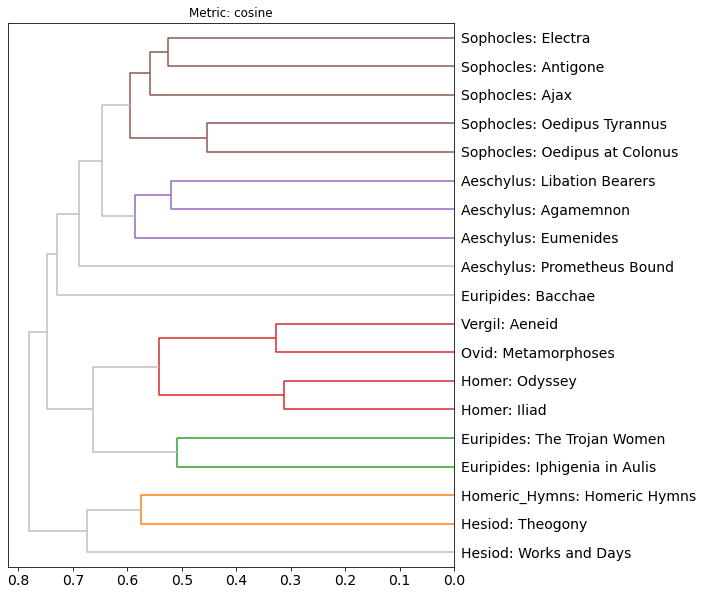

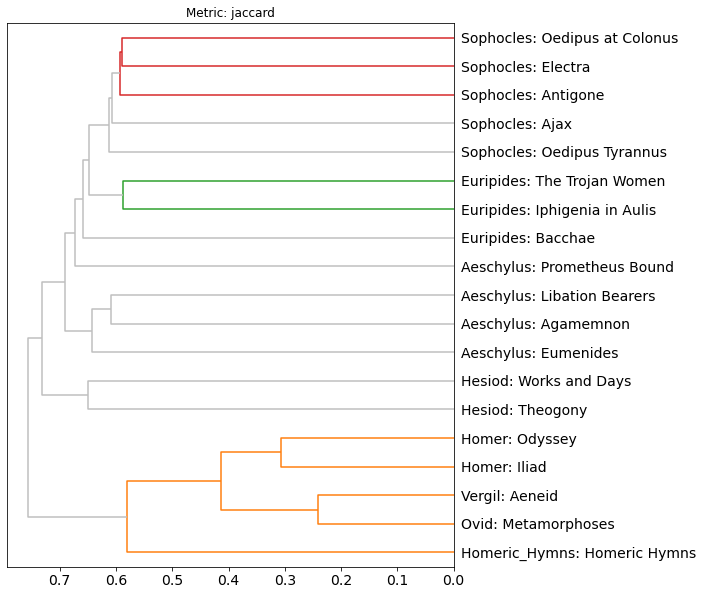

In [7]:
hca = HierarchicalClusterAnalysis(max_features=6000, tfidf_method='max', OHCO_level=chapter_bag)
hca.fit(corp, metrics=['cosine', 'jaccard'])
hca.plot_dendrogram(linkage='complete', color_thresh=0.6, figsize=(8, 10))

In [8]:
pca = PCA(max_features=6000, tfidf_method='max', OHCO_level=chapter_bag)
pca.fit(corp, n_components=10)

In [9]:
pca.dcm

pc_id                              PC0       PC1       PC2       PC3  \
author    work_id chapter_id                                           
Aeschylus 0       0           0.057463 -0.013699  0.010692  0.054303   
                  1           0.053546 -0.018407  0.017000  0.035325   
                  2           0.043499 -0.034823 -0.002784  0.037147   
                  3           0.071160 -0.018634 -0.022214  0.024113   
                  4           0.023404 -0.066506 -0.086415  0.005225   
...                                ...       ...       ...       ...   
Vergil    18      7          -0.252008 -0.298776  0.219349  0.036949   
                  8          -0.279114 -0.282574  0.191234  0.096666   
                  9          -0.278955 -0.304033  0.193182  0.101420   
                  10         -0.268133 -0.316492  0.165558  0.092460   
                  11         -0.290193 -0.300485  0.171238  0.099857   

pc_id                              PC4       PC5       PC6       PC7  \
author    work_id chapter_id                                           
Aeschylus 0       0          -0.075130  0.078110  0.047373 -0.047210   
                  1          -0.052493  0.083779  0.026870 -0.035367   
                  2          -0.070571  0.108543  0.052480 -0.055832   
                  3          -0.063721  0.035013  0.064893 -0.085575   
                  4          -0.070013  0.111915 -0.007863 -0.021276   
...                                ...       ...       ...       ...   
Vergil    18      7          -0.103889 -0.021951  0.159705  0.117858   
                  8          -0.117078 -0.001643  0.137434  0.150186   
                  9          -0.150108 -0.000079  0.159920  0.157199   
                  10         -0.120595  0.000601  0.168583  0.138234   
                  11         -0.126398 -0.038376  0.144948  0.140272   

pc_id                              PC8       PC9  
author    work_id chapter_id                      
Aeschylus 0       0          -0.013867  0.000371  
                  1          -0.027192 -0.050773  
                  2          -0.059227 -0.038015  
                  3          -0.030000 -0.038245  
                  4          -0.062806 -0.017980  
...                                ...       ...  
Vergil    18      7          -0.093779  0.083940  
                  8          -0.074472  0.121985  
                  9          -0.075987  0.102764  
                  10         -0.092245  0.120322  
                  11         -0.099438  0.095105  

[268 rows x 10 columns]

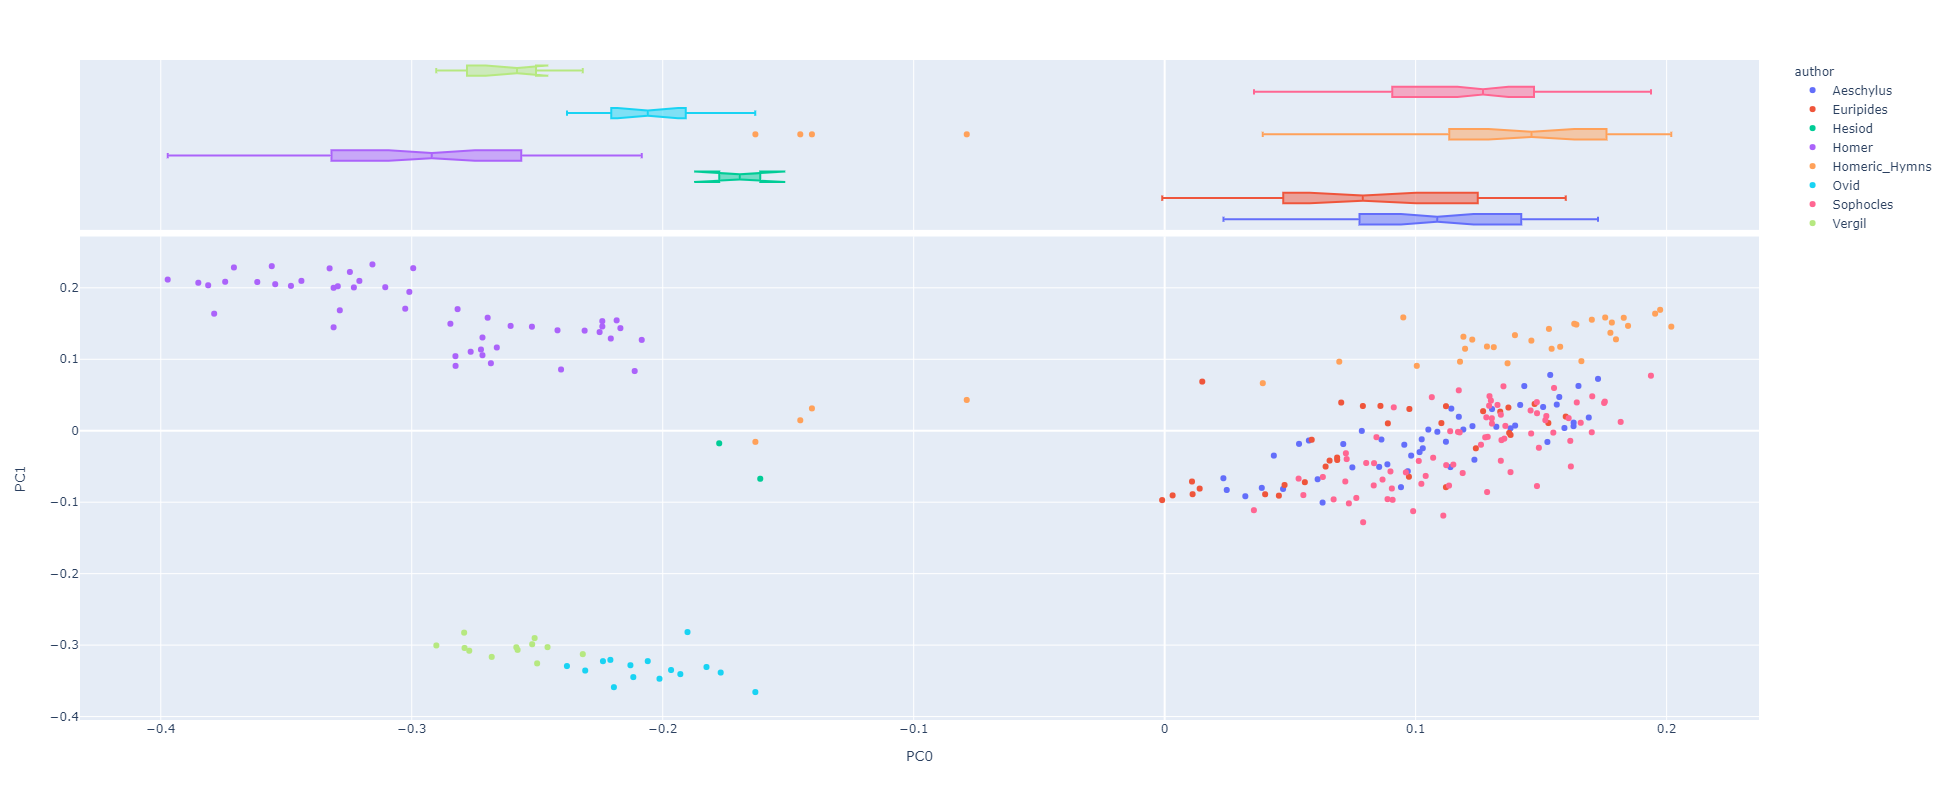

In [10]:
pca.plot_2d(comp_id_1=0, comp_id_2=1)

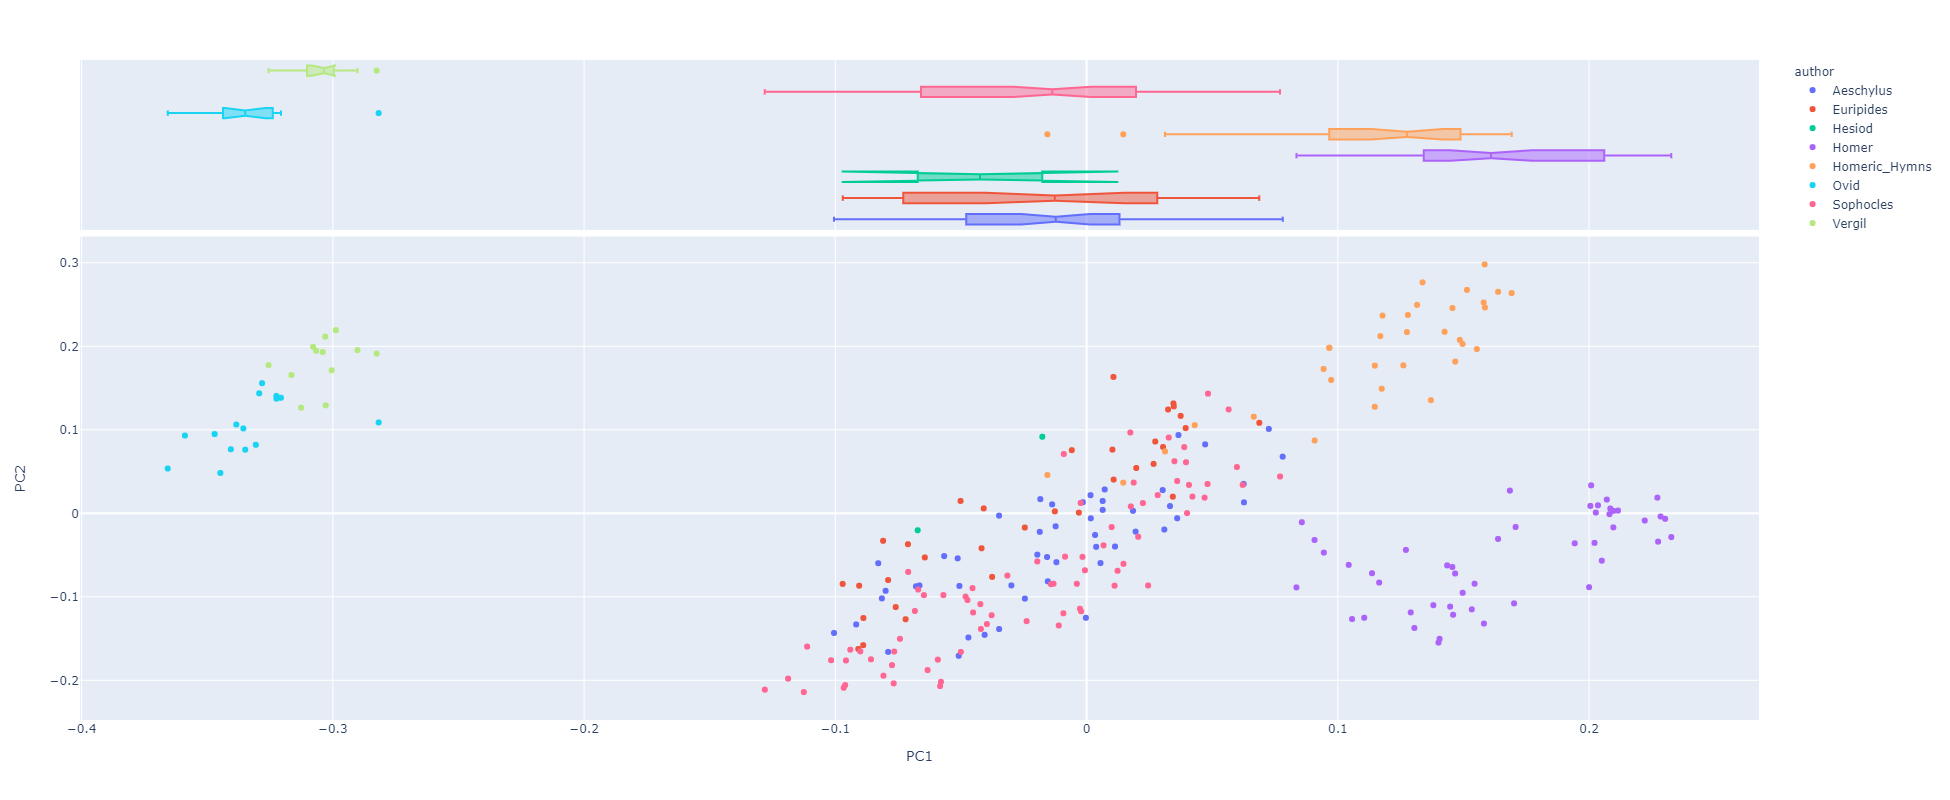

In [11]:
pca.plot_2d(comp_id_1=1, comp_id_2=2)

In [12]:
lda_topics = TopicModel()
lda_topics.fit(corp)

In [30]:
lda_topics.corpus.token[lda_topics.corpus.token.pos.str.match(r'^NNP?S?$')].groupby(['work_id', 'chapter_id']).term_str.apply(lambda x: ' '.join(x)).to_frame()

TypeError: sequence item 215: expected str instance, float found

In [32]:
for work, chap in lda_topics.corpus.token[lda_topics.corpus.token.pos.str.match(r'^NNP?S?$')].groupby(['work_id', 'chapter_id']).term_str:
    print(work, chap)

(0, 0) work_id  chapter_id  para_id  sent_id  token_id
0        0           0        0        0             watchman
                                       1              release
                                       5                 task
                                       7                 mine
                                       11                plea
                                                      ...    
                     1        12       34          sacrifices
                                       35               wards
                                       39                care
                                       42              sorrow
                                       46               heart
Name: term_str, Length: 246, dtype: object
(0, 1) work_id  chapter_id  para_id  sent_id  token_id
0        1           0        0        0            chorus
                                       4             power
                                       8       

In [36]:
lda_topics.corpus.token.term_str.str.cat(sep=' ')

'watchman release from this weary task of mine has been my plea to the gods throughout this long years watch in which lying upon the palace roof of the atreidae upon my bent arm like a dog i have learned to know well the gathering of the nights stars those radiant potentates conspicuous in the firmamentbringers of winter and summer to mankind the constellations when they rise and setso now i am still watching for the signal flame the gleaming fire that is to bring news from troy andtidings of its capture for thus commands my queen woman in passionate heart and man in strength of purpose and whenever i make here my bed restless and dank with dew and unvisited by dreamsfor instead of sleep fear stands ever by my sideso that i cannot close my eyelids fast in sleepand whenever i care to sing or hum and thus apply an antidote of song to ward off drowsiness then my tears start forth as i bewail the fortunes of this house of ours not ordered for the best as in days gone bybut tonight may ther

In [13]:
# # Saving tables
# corp.save_tables(os.path.join(output_dir, 'corpus'))